In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from casadi import MX, vertcat, if_else, sqrt, integrator, interpolant
import torch
import torch.nn as nn
import torch.optim as optim
import time




In [3]:
# Definir a seed
seed = 43
seed2 = 42
seed3 = 42
np.random.seed(seed)

random.seed(seed)


In [4]:
# Normalização de dados para o intervalo [-1, 1]
def normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = 2 * (Mat_dados[:, i] - min_value) / (max_value - min_value) - 1
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = 2 * (Mat_dados[:] - min_value) / (max_value - min_value) - 1

    return result





# Desnormalização de dados do intervalo [-1, 1] para os valores originais
def des_normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = (Mat_dados[:, i] + 1) * (max_value - min_value) / 2 + min_value
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] + 1) * (max_value - min_value) / 2 + min_value


    return result





# Normalização de dados para as redes.
def zero_normalize(Mat_ref,Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
                max_value = Mat_ref[:,i].max()
                min_value = Mat_ref[:,i].min()
                result[:,i] = (Mat_dados[:,i] - min_value) / (max_value - min_value)
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] - min_value) / (max_value - min_value)

    return result
# Desnormalização de dados para as redes.
def zero_des_normalize(Mat_ref,Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            max_value = Mat_ref[:,i].max()
            min_value = Mat_ref[:,i].min()
            result[:,i] = (Mat_dados[:,i] ) * (max_value - min_value) + min_value
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] ) * (max_value - min_value) + min_value

    return result

In [5]:
import pandas as pd


def create_interpolation(file_path, decimal=','):

    # Carregar os dados do CSV
    data = pd.read_csv(file_path, decimal=decimal)
    
    # Configurar os eixos da malha
    N_rot = np.arange(2e4, 6e4, 1e3)  # De 20000 rpm a 60000 rpm, Shape: (40,)
    Mass = np.arange(3, 21.1, 0.1)   # De 3 a 21, Shape: (181,)
    Phi = data.values                # Valores da tabela, Shape: (40,181)
    
    # Linearizar a matriz Phi para criação da LUT
    phi_flat = Phi.ravel(order='F')
    
    # Criar a LUT usando interpolação b-spline
    lut = interpolant('name', 'bspline', [N_rot, Mass], phi_flat)
    
    return lut

# Caminho para o arquivo CSV
file_path = r"C:\Users\fabio\Downloads\tabela_phi.csv"

# Chamar a função e obter a LUT
interpolation = create_interpolation(file_path)

N_rot_example = 40412.61691244799
Mass_example = 9.62476391 
result = interpolation([N_rot_example, Mass_example]) 

# Exibir o resultado
print(f"Interpolação para N_rot={N_rot_example}, Mass={Mass_example}: {result}")

Interpolação para N_rot=40412.61691244799, Mass=9.62476391: 1.49599


In [6]:

class P1Generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def P1(self):
        while True:
            value = np.random.uniform(4500, 4700)  # KPa
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value



class N_generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def N(self):
        while True:
            value = np.random.uniform(40e3, 46e3)  #Hz   # 4e4, 5e4
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value
            



p1_gen = P1Generator(seed)
N_gen = N_generator(seed)

In [7]:
def Estacionario(X):
    x = X
  # Constantes
    A1 = 2.6e-3        # m²
    L_c = 2.0          # m
    alpha = 0.75    #  Constante de Abertura da Valvula
    P_out = 5000       # KPa
    C1 = 479.029       # Constante
    V_p = 2.0          # m³
    K_nu = 0.38 
    0 #0.0765      # kg / (kPa^0.5 s)
    phi = interpolation([45000, x[0]]).__float__() 

    z = 0 if x[1] < P_out else np.sqrt(x[1]   - P_out)

    dmdt = (A1 / L_c) * (phi * 5000 - x[1])*1000 
    dPdt = (C1**2/V_p) * (x[0] - alpha * K_nu * sqrt(x[1] - P_out))/1000
    return [dmdt, dPdt]

stati = fsolve(Estacionario, [10, 9e3])

print(stati,Estacionario(stati))

[  13.40272212 7211.54768046] [np.float64(-4.8814217734616246e-08), np.float64(-1.0347394145815488e-09)]


In [8]:
def Sistemas(x0, P1_value, interpolant_function, N_value):
    x = MX.sym('x', 2)  #
    p = MX.sym('p',2)
    start = time.time()

    #N = p[1]
    phi = interpolant_function(vertcat(p[1], x[0]))
    
    # Constantes
    A1 = 2.6e-3          # m²
    L_c = 2.0            # m
    alpha = 0.75        # Constante Abertura da valvula
    P_out = 5000         #  kPa
    C1 = 479.029         # Constante Velocidade do Som na Entrada do Compressor 
    V_p = 2.0            # m³
    K_nu = 0.38          # kg / (kPa^0.5 s)
    phi_value = 1.5      # 

    z = if_else(x[1] < P_out, 0, sqrt(x[1] - P_out))
    non = if_else(phi<0,phi+1,phi)
    
    rhs = vertcat(
        (A1 / L_c) * ( non* p[0] - x[1] )*1000,                                     # Vazão Massica/ dt
        (C1**2 / V_p) * (x[0] - alpha* K_nu * sqrt(x[1] - P_out))/1000                             # Pressão do Plenum / dt
    ) 

    ode = {'x': x, 'ode': rhs , 'p': p}
    
    F = integrator('F', 'cvodes', ode)

    #
    t_eval = np.linspace(0, 10,40)
    sol = np.zeros((len(t_eval), 2))
    zeronum = 1e-9
    sol[0,:] = x0
    #
    print(P1_value, N_value)
    for i in range(len(t_eval)-1):
        param = [P1_value, N_value]
        res = F(x0=x0, p=param)
        x_next = res['xf'].full().flatten()
        sol[i+1] = x_next
        # Update initial state
        x0 = x_next

    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    
    return sol, P1_value,N_value, t_eval
    


In [9]:
def Loop(loops, stati):
    estados = []
    p1_total = []
    N_total = []
    t_eval_total = []
    for i in range(loops):
        if i == 0:
            x0 = stati  # Estado inicial
        else:
            x0 = estados[-1][-1]
        print(x0)
        P1_v = p1_gen.P1()  # Geração aleatória de P1
        N_v = N_gen.N()
        sol, P1_aleatorio,aaaa, t_eval = Sistemas(x0, P1_v, interpolation, N_v)
        estados.append(sol)
        N_total.append(aaaa)
        p1_total.append(P1_aleatorio)
        
        # Concatenar tempo
        if i == 0:
            t_total = t_eval
        else:
            t_total = np.concatenate([t_total, t_total[-1] + t_eval])

    return estados, p1_total, N_total, t_total

[  13.40272212 7211.54768046]
4589.412224699483 44261.048798782336
Tempo de execução: 0.006420135498046875 segundos
[  12.39214114 6890.61449033]
4625.214265526009 44023.89862126751
Tempo de execução: 0.007814168930053711 segundos
[  12.38209219 6887.54948594]
4694.383771969338 43971.827445315015
Tempo de execução: 0.006781816482543945 segundos
[  12.50328888 6924.68122946]
4518.290040471533 43538.38606125777
Tempo de execução: 0.00962376594543457 segundos
[  11.97712912 6766.10183906]
4542.316201281254 44770.45380999738
Tempo de execução: 0.007735729217529297 segundos
[  12.47526465 6916.06313333]
4570.06119644557 43014.61886585894
Tempo de execução: 0.009156942367553711 segundos
[  11.90477066 6744.82689292]
4640.707829226319 41029.76605550763
Tempo de execução: 0.008067607879638672 segundos
[  11.35961139 6588.68292822]
4620.211888226438 40960.20766443435
Tempo de execução: 0.007722377777099609 segundos
[  11.28989213 6569.24178926]
4665.315680269118 41996.20977095511
Tempo de execu

C:\Users\fabio\AppData\Local\Temp\ipykernel_16408\3702221798.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\fabio\AppData\Local\Temp\ipykernel_16408\3702221798.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 3000x100 with 0 Axes>

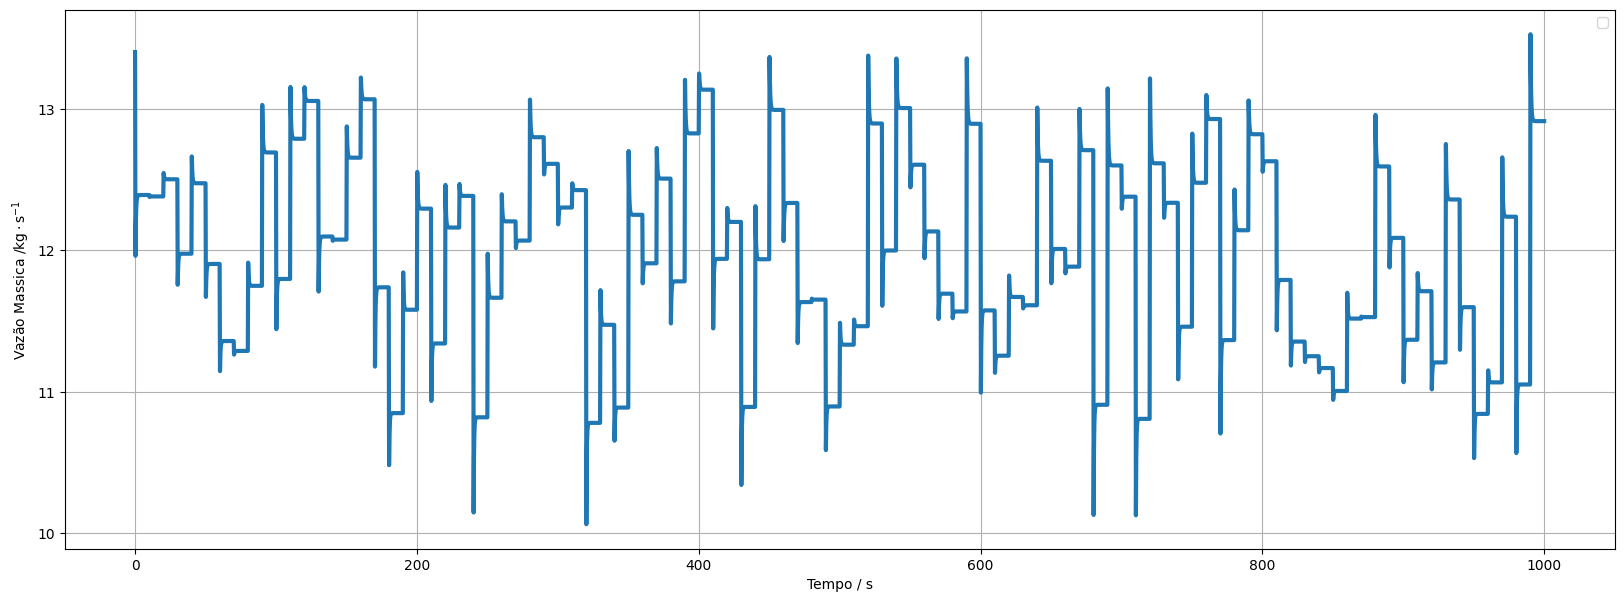

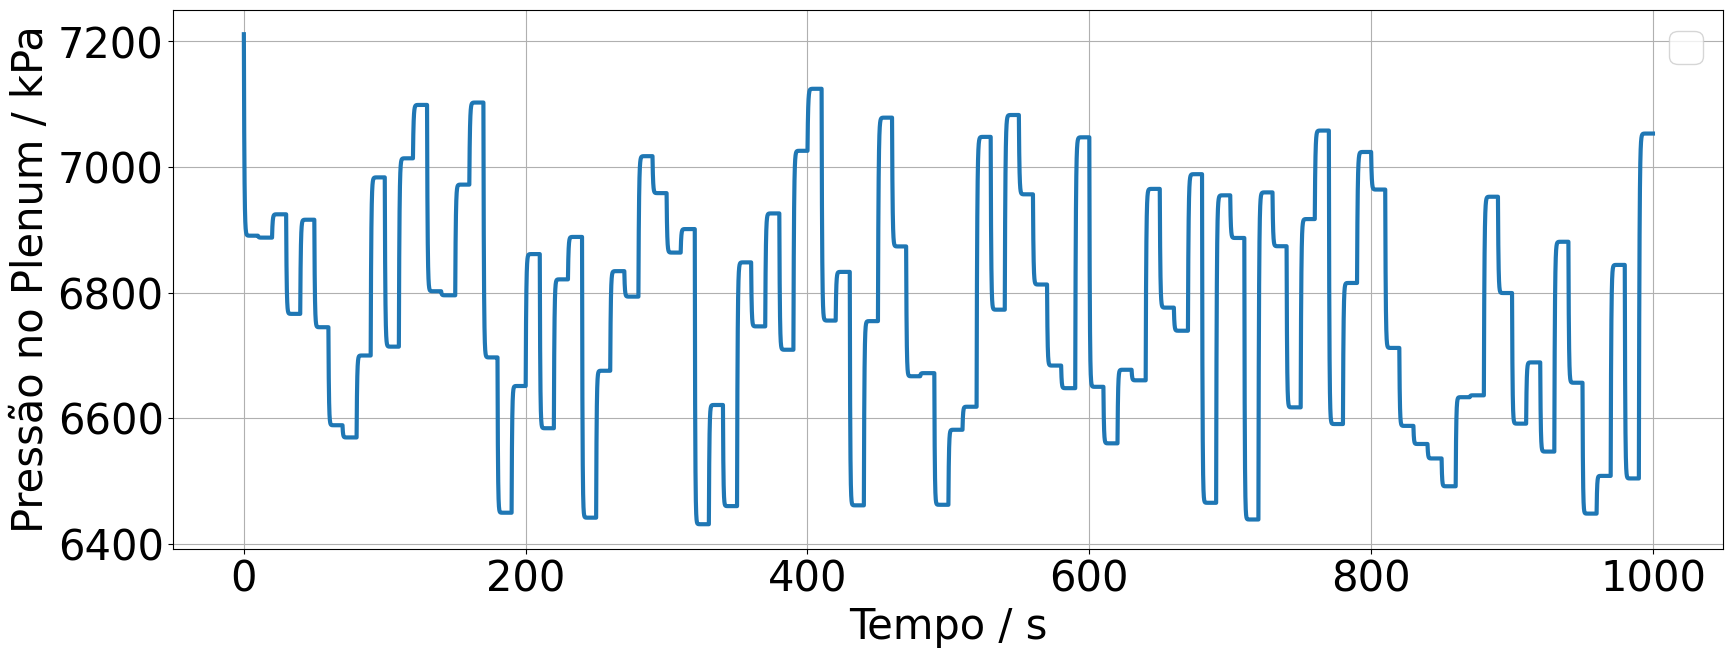

In [11]:

aaaa, PlotP1, PlotN, Plott = Loop(100, stati)



bbb = aaaa
print(PlotP1)
Ploty = np.concatenate(aaaa)
M_final = Ploty[:, 0]

P_p_final = Ploty[:,1]

# Plotar os resultados

plt.figure(figsize=(30, 1))

# Plot para M (Mass Flow Rate)
plt.figure(figsize=(20, 7))

plt.plot(Plott,Ploty[:, 0],linewidth=3)
plt.xlabel('Tempo / s')
plt.ylabel(r'Vazão Massica $\mathrm{/kg \cdot s^{-1}}$')
plt.legend()
#plt.xlim(0,480)
#plt.ylim(10,14)
plt.xlabel('Tempo / s')
plt.grid(True)
plt.rcParams.update({'font.size': 30})

plt.figure(figsize=(20, 7))

plt.plot(Plott,Ploty[:, 1], linewidth=3)
plt.xlabel('Tempo / s')
#plt.xlim(0,480)
plt.rcParams.update({'font.size': 30})
plt.ylabel('Pressão no Plenum / kPa')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Dados para treino
M_Ploty = np.vstack(bbb)
t_eval = np.hstack(Plott)
P1_values = np.array(PlotP1)
N_values = np.array(PlotN)
M = M_Ploty[:, 0]
P_p = M_Ploty[:, 1]


# Garantindo que as repetições sejam suficientes
repeated_P1 = np.repeat(P1_values, -(-len(M[:-1]) // len(P1_values)))[:len(M[:-1])]
repeated_N = np.repeat(N_values, -(-len(M[:-1]) // len(N_values)))[:len(M[:-1])]

# Entradas e Saídas (Many to Many)
X = np.column_stack((M[:-1], P_p[:-1], repeated_P1, repeated_N))
y = np.column_stack((M[1:], P_p[1:]))
print(X.shape, y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)      

(3999, 4) (3999, 2)


In [25]:
X_test_ref = X_test
y_test_ref = y_test
X_train = normalize(X_train,X_train)
X_test =   normalize(X_test,X_test)
y_train = normalize(y_train,y_train)
y_test =   normalize(y_test,y_test)

In [24]:
X_train.shape

(2799, 2)

In [ ]:


# Converter para tensores PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) # Adiciona dimensão de sequência
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
noise_std = 0.001 
X_train_tensor = X_train_tensor + torch.randn_like(X_train_tensor) * noise_std
X_test_tensor = X_test_tensor + torch.randn_like(X_test_tensor) * noise_std


In [29]:
y_train_tensor.shape

torch.Size([2799, 2])

In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        
        # Camada LSTM bidirecional
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=False)
        
        self.dense_layers = nn.Sequential(
        nn.Linear(hidden_dim, 32),  
        nn.Tanh(),
        nn.Linear(32, 32),
        nn.Tanh(),
        nn.Linear(32, 2),
    )
    def forward(self, input_seq, future_steps=0):
        batch_size, seq_len, _ = input_seq.shape

        # Inicializando os estados ocultos e de célula
        h_0 = torch.zeros(1, batch_size, self.lstm.hidden_size, dtype=torch.float32)
        c_0 = torch.zeros(1, batch_size, self.lstm.hidden_size, dtype=torch.float32)

        # Passagem pela LSTM com sequência de entrada completa
        lstm_out, (h_n, c_n) = self.lstm(input_seq, (h_0, c_0))

        # Pegando a saída do último timestep da sequência original
        last_output = lstm_out[:, -1, :]


        # Passagem pelas camadas densas
        x = self.dense_layers(last_output)

        predictions = [x]  # Armazena a previsão inicial

        # Predição recursiva para futuros timesteps
        for _ in range(future_steps):
            x = x.unsqueeze(1)  # Ajusta dimensão para (batch, 1, features)
            
            # Passa a previsão anterior como nova entrada para a LSTM
            lstm_out, (h_n, c_n) = self.lstm(x, (h_n, c_n))
            last_output = lstm_out[:, -1, :]

            # Passa pelas camadas densas
            x = self.dense_layers(last_output)

            predictions.append(x)

        # Concatena todas as previsões futuras
        return torch.cat(predictions, dim=1)


In [ ]:
batch_size, _, input_size = X_train_tensor.shape


seq_len = 5  # Número de time steps desejado


# Reorganizar os dados para incluir time steps
new_X_train = []
nex_X_test = []
for i in range(len(X_train_tensor) - seq_len + 1):
    new_X_train.append(X_train_tensor[i:i + seq_len, 0, :])
    
# Converter lista para tensor
new_X_train_tensor = torch.stack(new_X_train)
new_y_train_tensor = y_train_tensor[seq_len-1:]

print("Novo shape de X_train_tensor:", new_X_train_tensor.shape)
print("Shape de y_train_tensor[seq_len-1:]:", y_train_tensor[seq_len-1:].shape) 

# Criar as sequências temporais para X_test_tensor
new_X_test = []
for i in range(len(X_test_tensor) - seq_len + 1):
    new_X_test.append(X_test_tensor[i:i + seq_len, 0, :])

# Converter para tensor
new_X_test_tensor = torch.stack(new_X_test)

# Ajustar y_test_tensor (remover os primeiros seq_len-1 elementos)
new_y_test_tensor = y_test_tensor[seq_len-1:]

# Verificar os shapes
print("Shape de new_X_test_tensor:", new_X_test_tensor.shape)  
print("Shape de new_y_test_tensor:", new_y_test_tensor.shape)  

# Definir parâmetros do modelo
input_dim = X_train_tensor.shape[-1]
output_dim = y_train_tensor.shape[-1]

# Treinamento do modelo
n_epochs = 5000
batch_size = 32
early_stop_patience = 100

print(batch_size)

Novo shape de X_train_tensor: torch.Size([2795, 5, 4])
Shape de y_train_tensor[seq_len-1:]: torch.Size([2795, 2])
Shape de new_X_test_tensor: torch.Size([1196, 5, 4])
Shape de new_y_test_tensor: torch.Size([1196, 2])
32


In [ ]:


train_data = torch.utils.data.TensorDataset(new_X_train_tensor, new_y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_data = torch.utils.data.TensorDataset(new_X_test_tensor, new_y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
import optuna 
from optuna.trial import TrialState

def objective(trial):
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3)
    #hidden_dim = trial.suggest_int("hidden_dim", 10, 90)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)

    model = LSTMModel(input_dim, 32, output_dim, dropout_rate)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in test_loader:
            optimizer.zero_grad
            ()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    return loss.item()

c:\Users\fabio\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

# Rodar a otimização com Optuna
#study = optuna.create_study(direction='minimize') #sampler=optuna.samplers.RandomSampler(seed=42))
#study.optimize 

In [ ]:
#study.optimize(objective, n_trials=15)
#print(study.best_params
      

In [ ]:
from plotly.io import show
#optuna.visualization.matplotlib.plot_param_importances(study)
#optuna.visualization.matplotlib.plot_optimization_history(study)
torch.manual_seed(seed)

In [ ]:
{'dropout_rate': 0.26511774341311967, 'hidden_dim': 46, 'learning_rate': 8.076191014209005e-05}
{'dropout_rate': 0.18527381943769, 'hidden_dim': 55, 'learning_rate': 1.0075975105986993e-05}
torch.manual_seed(seed)


In [ ]:
class CustomMSELoss(nn.Module):
    def __init__(self, weights):
        """
        Inicializa a função de perda personalizada.
        :param weights: Lista ou tensor de pesos para cada saída (ex: [0.001, 1.0]).
        """
        super(CustomMSELoss, self).__init__()
        self.weights = torch.tensor(weights)

    def forward(self, outputs, targets):
        """
        Calcula o erro quadrático médio ponderado.
        :param outputs: Saídas preditas pelo modelo (batch_size, output_dim).
        :param targets: Valores reais (batch_size, output_dim).
        :return: Escalar com o erro médio ponderado.
        """
        # Calcula a diferença quadrada entre outputs e targets
        squared_error = (outputs - targets) ** 2

        # Pondera o erro para cada dimensão de saída
        weighted_error = squared_error * self.weights

        # Retorna a média dos erros ponderados
        return weighted_error.mean()


In [ ]:
#<torch._C.Generator at 0x185485dfd30>


#best_params = study.best_params
# Definir parâmetros do modelo
hidden_dim = 32 #best_params['hidden_dim']  
dropout_rate = 0.268527381943769 #best_params['dropout_rate'] 
learning_rate =  1.076191014209005e-03 #best_params['learning_rate'] 


In [ ]:

# Inicializar o modelo, função de perda e otimizador
model1 = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)

In [ ]:

# Definindo pesos e critério
weights = [9, 1000]  # Pesos para cada saída
criterion = nn.MSELoss() #CustomMSELoss(weights)  # Substitua por seu critério personalizado
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

# Para armazenar as perdas de treino e validação
train_losses = []
val_losses = []
best_loss = float('inf')
patience = 0
early_stop_patience = 4000  # Defina o valor desejado para a paciência

for epoch in range(n_epochs):
    model1.train()
    batch_train_losses = []  # Reinicia as perdas do batch a cada época

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model1(X_batch)  # Ouça se o modelo precisa de algo diferente para a entrada

        # Cálculo da perda
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        # Armazena a perda do batch
        batch_train_losses.append(loss.item())

    # Perda média do treino na época atual
    train_loss = np.mean(batch_train_losses)
    train_losses.append(train_loss)

    # Validação
    model1.eval()
    with torch.no_grad():
        batch_val_losses = []
        for X_val, y_val in test_loader:
            y_pred_val = model1(X_val)
            val_loss = criterion(y_pred_val, y_val)
            batch_val_losses.append(val_loss.item())

        val_loss = np.mean(batch_val_losses)
        val_losses.append(val_loss)

    # Early stopping: se a perda de validação melhorar, salva o modelo
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        best_model = model1.state_dict()  # Salva os melhores pesos do modelo
    else:
        patience += 1
        if patience >= early_stop_patience:
            print("Early stopping")
            break

    # Exibição das perdas
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

# Carregar o melhor modelo salvo
model1.load_state_dict(best_model)



Epoch 1/5000, Train Loss: 0.103384, Val Loss: 0.019551
Epoch 2/5000, Train Loss: 0.010428, Val Loss: 0.015432
Epoch 3/5000, Train Loss: 0.007355, Val Loss: 0.012502
Epoch 4/5000, Train Loss: 0.005484, Val Loss: 0.010672
Epoch 5/5000, Train Loss: 0.004027, Val Loss: 0.009401
Epoch 6/5000, Train Loss: 0.002918, Val Loss: 0.008143
Epoch 7/5000, Train Loss: 0.002158, Val Loss: 0.006678
Epoch 8/5000, Train Loss: 0.001591, Val Loss: 0.005746
Epoch 9/5000, Train Loss: 0.001141, Val Loss: 0.005556
Epoch 10/5000, Train Loss: 0.000833, Val Loss: 0.005870
Epoch 11/5000, Train Loss: 0.000785, Val Loss: 0.006274
Epoch 12/5000, Train Loss: 0.000644, Val Loss: 0.006149
Epoch 13/5000, Train Loss: 0.000711, Val Loss: 0.006228
Epoch 14/5000, Train Loss: 0.000556, Val Loss: 0.005778
Epoch 15/5000, Train Loss: 0.000660, Val Loss: 0.005956
Epoch 16/5000, Train Loss: 0.000504, Val Loss: 0.005431
Epoch 17/5000, Train Loss: 0.000635, Val Loss: 0.005618
Epoch 18/5000, Train Loss: 0.000441, Val Loss: 0.005092
E

<All keys matched successfully>

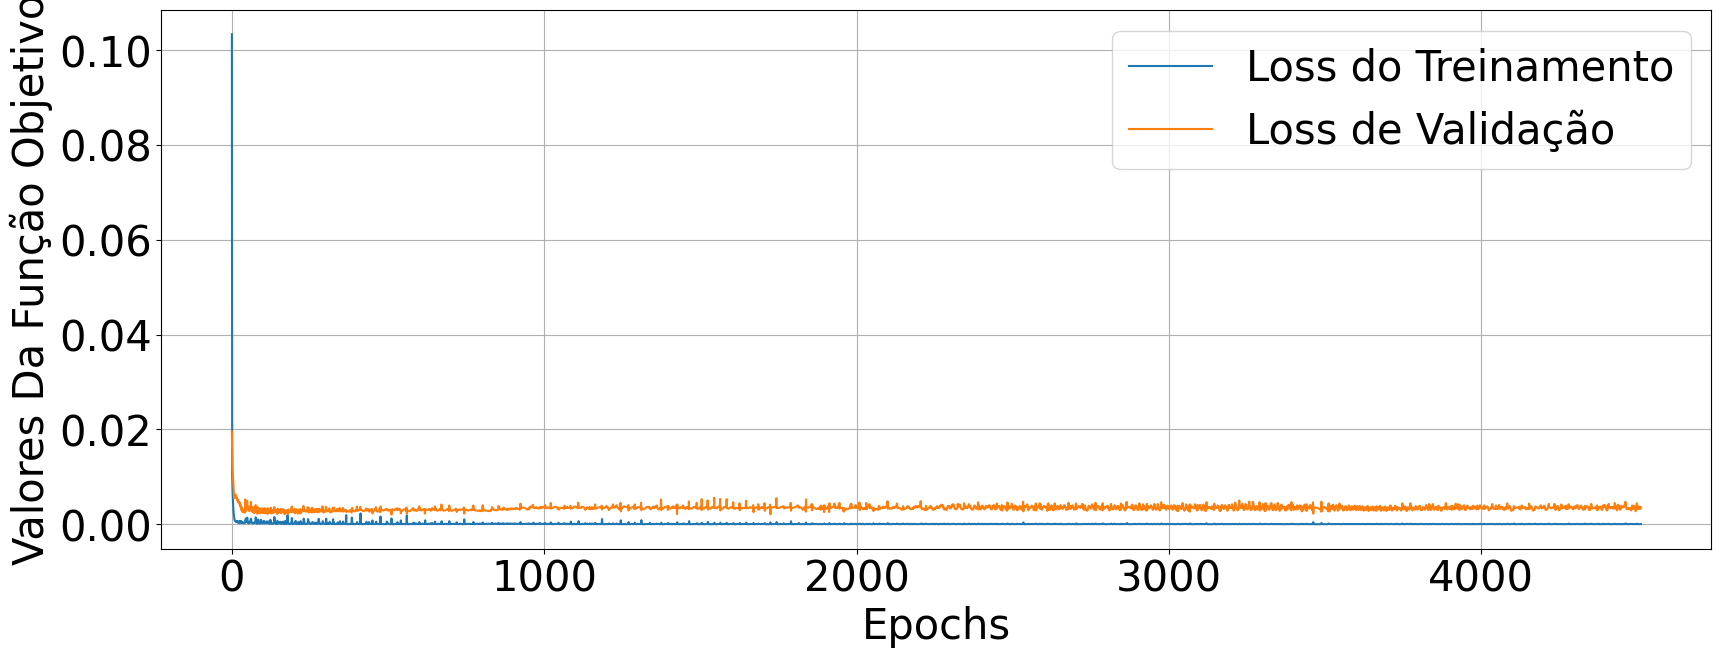

In [ ]:
plt.figure(figsize=(20, 7))
#{'dropout_rate': 0.12203289501741924, 'hidden_dim': 56, 'learning_rate': 4.67573896148755e-05}
plt.plot(train_losses, label='Loss do Treinamento')
plt.plot(val_losses, label='Loss de Validação')
#plt.plot(history.history[.'val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')

plt.ylabel('Valores Da Função Objetivo')

plt.grid()
plt.show()

In [ ]:
torch.manual_seed(seed)

In [ ]:
new_X_test_tensor.shape

torch.Size([596, 5, 4])

In [ ]:
new_y_test_tensor.shape

torch.Size([596, 2])

In [ ]:
y_test_pred_original.shape

torch.Size([596, 2])

Tempo de execução: 0.08490490913391113 segundos
torch.Size([1196, 2])
[[0.45447896 0.66696435]
 [0.2743184  0.56198435]
 [0.29855628 0.50725181]
 ...
 [0.63866684 0.98460344]
 [0.63866684 0.98460344]
 [0.63866684 0.98460344]]


<Figure size 3000x100 with 0 Axes>

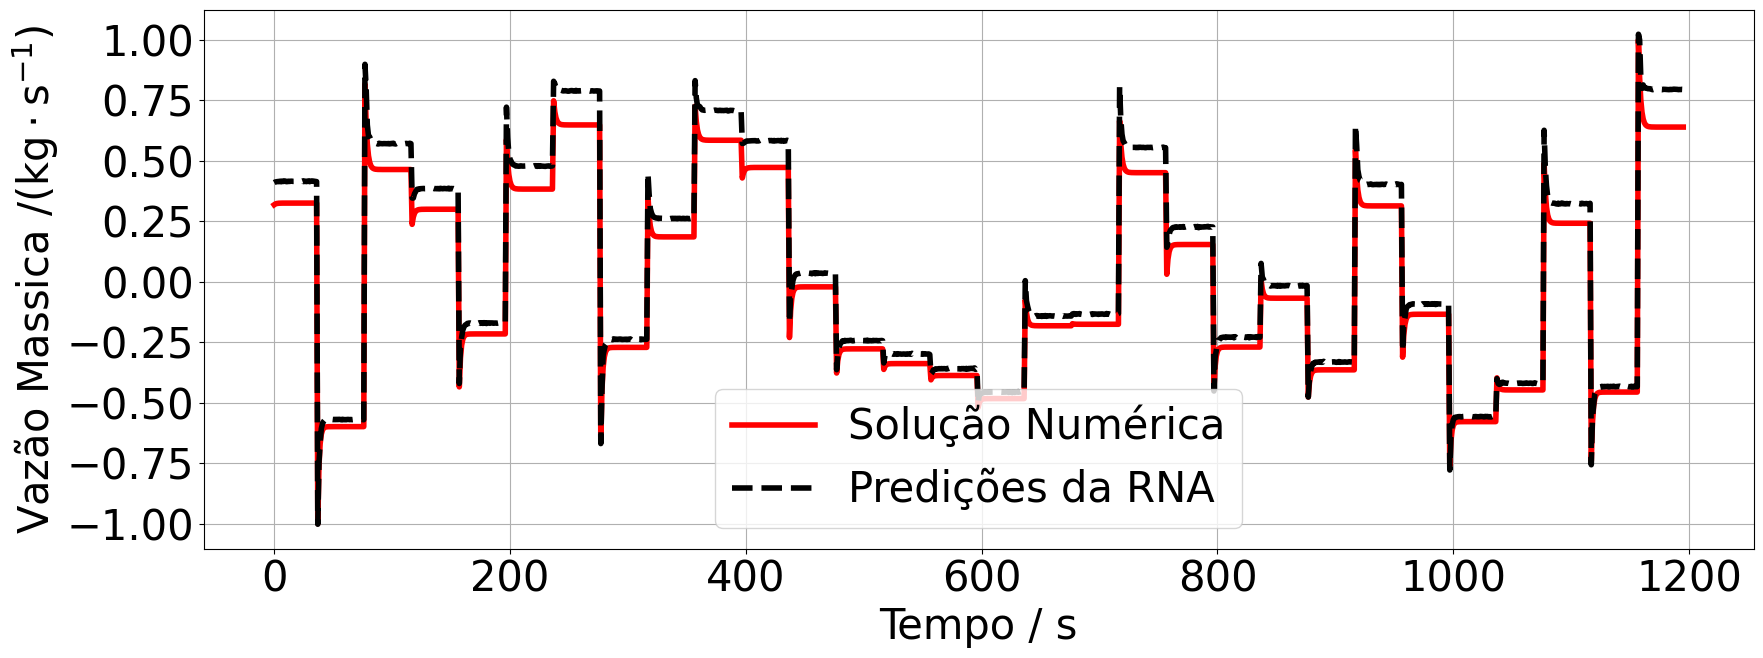

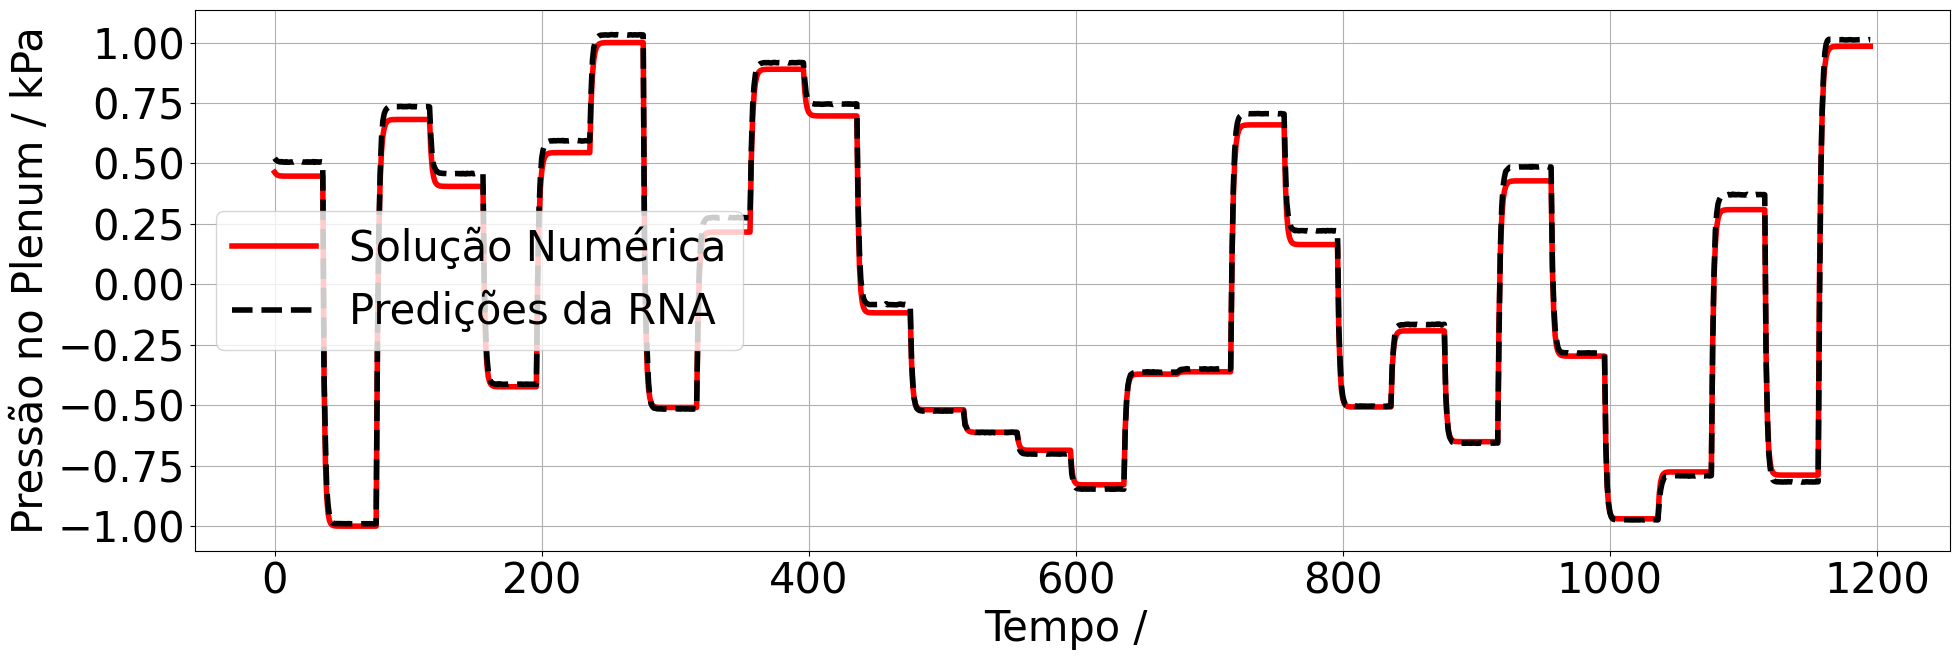

In [ ]:
mse = nn.MSELoss()
with torch.no_grad():
    start = time.time()
    y_test_pred = model1(new_X_test_tensor).squeeze(1)
    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")


print(y_test_pred.shape)
y_test_pred_original = y_test_pred
y_test_original = y_test
print(y_test_original)

plt.figure(figsize=(30, 1))

# Plot para M (Mass Flow Rate)
plt.figure(figsize=(20, 7))
plt.plot(new_y_test_tensor[:, 0], label="Solução Numérica", color="red", linewidth=4)

plt.plot(y_test_pred_original[:, 0], "--", label="Predições da RNA", color="black", linewidth=4)
plt.xlabel('Tempo / s')
plt.ylabel(r'Vazão Massica $\mathrm{/(kg \cdot s^{-1})}$')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.figure(figsize=(20, 7))
plt.plot(new_y_test_tensor[:, 1], label="Solução Numérica", color="red", linewidth=4)
plt.plot(y_test_pred_original[:, 1], "--", label="Predições da RNA", color="black", linewidth=4)
plt.xlabel('Tempo / ')
plt.ylabel('Pressão no Plenum / kPa')
plt.legend()
plt.rcParams.update({'font.size': 20})
plt.grid(True)

# Ajustar o layout e mostrar o gráfico

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
default_dpi = 96
time_x = np.arange(len(tempos))
tempos = tempos
print(tempos)
def save_or_show(filename: str | None = None):
    if filename is None:
        plt.show()
    else:
        plt.savefig(save_folder + filename)
        plt.clf()
        plt.close()

In [ ]:
def plot_density(values, labels, metric, filename: str | None = None):
    plt.figure(figsize=(10, 4), layout="constrained", dpi=default_dpi)
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    for i in range(len(values)):
        sns.histplot(
            values[i],
            kde=True,
            label=labels[i],
            stat="density",
            bins=100,
            color=colors[i],
        )

        mean_value = np.mean(values[i])
        plt.axvline(
            mean_value,
            linestyle="--",
            linewidth=1.5,
            color=colors[i],
        )

    plt.xlabel(metric)
    plt.xlim(0.12, max(values[0]))
    plt.ylabel("Densidade de Probabilidade")
    plt.grid()
    plt.legend()

plot_density([tempos], ["Tempo de Execução"], "Tempo de Execução/s")

In [ ]:
#torch.save(model, r"C:\Users\fabio\PycharmProjects\PRH-1\model\model22222222.pth")